In [1]:
import os
#os.chdir('..') # go back to the root directory

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import json
import glob
import random
import os

In [2]:
n_folds = 5
n_bins = 20
eval_names = ['onset', 'gpt2_surprisal', 'word_part_speech', 'word_index', 'word_length', 'volume', 'word_head_pos']
eval_names = ['onset', 'gpt2_surprisal', 'volume', 'word_head_pos']

test_roc_scores = np.zeros((len(eval_names), n_folds, n_bins), dtype=np.float32)

# Load ROC scores from saved files
for eval_idx, eval_name in enumerate(eval_names):
    for fold in range(1, n_folds+1):
        filename = f"eval_results/per_bin_linear_voltage_{eval_name}_fold{fold}_test.npy"
        try:
            scores = np.load(filename)
            test_roc_scores[eval_idx, fold-1, :] = scores.flatten()
        except FileNotFoundError:
            print(f"Warning: File not found: {filename}")

# Set bin size for time calculations
bin_size = 128  # Assuming 256 samples per bin
bins_before_onset = 4

In [3]:
task_name_mapping = {
    'onset': 'Sentence Onset',
    'speech': 'Speech',
    'volume': 'Audio Volume', 
    'pitch': 'Audio Pitch',
    'speaker': 'Speaker Identity',
    'delta_volume': 'Delta Volume',
    'delta_pitch': 'Delta Pitch',
    'gpt2_surprisal': 'GPT-2 Surprisal',
    'word_length': 'Word Length',
    'word_gap': 'Inter-word Gap',
    'word_index': 'Word Position',
    'word_head_pos': 'Head Word Position',
    'word_part_speech': 'Part of Speech',
    'frame_brightness': 'Frame Brightness',
    'global_flow': 'Global Optical Flow',
    'local_flow': 'Local Optical Flow',
    'global_flow_angle': 'Global Flow Angle',
    'local_flow_angle': 'Local Flow Angle',
    'face_num': 'Number of Faces',
}

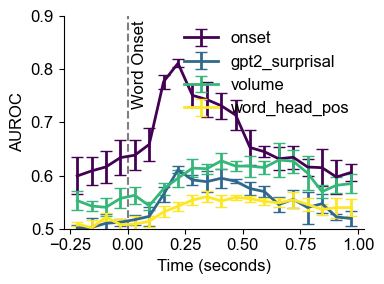

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'figures/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Calculate mean and std of test ROC AUC scores across folds for all features
mean_test_rocs = np.mean(test_roc_scores, axis=1) # Shape: (n_features, n_bins)
std_test_rocs = np.std(test_roc_scores, axis=1) # Shape: (n_features, n_bins)

# Create time points (in seconds) for x-axis
bin_times = (np.arange(n_bins)-bins_before_onset + 0.5) * (bin_size/2048)

# Get colors from viridis colormap spread across number of features
colors = plt.cm.viridis(np.linspace(0, 1, len(eval_names)))

# Create the plot
plt.figure(figsize=(4, 3))

# Plot mean and error bars for each feature
for i, eval_name in enumerate(eval_names):
    plt.errorbar(bin_times, mean_test_rocs[i], yerr=std_test_rocs[i], 
                linewidth=2, color=colors[i], label=eval_name, capsize=4)

# Add vertical line at word onset (t=0) that goes up to 0.8
plt.vlines(x=0, ymin=0.5, ymax=1.0, color='k', linestyle='--', alpha=0.5)
plt.text(0.02, 0.98, 'Word Onset', rotation=90, 
         transform=plt.gca().get_xaxis_transform(),
         verticalalignment='top')

# Customize the plot
plt.xlabel('Time (seconds)')
plt.xticks([-0.25, 0, 0.25, 0.5, 0.75, 1])
plt.ylabel('AUROC')
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.legend(loc='upper right', frameon=False, ncol=1)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set y-axis limits with some padding
plt.ylim(0.5, 0.9)

# Show the plot
plt.tight_layout()
plt.savefig('figures/linear_per_bin_auroc.pdf', dpi=300, bbox_inches='tight')

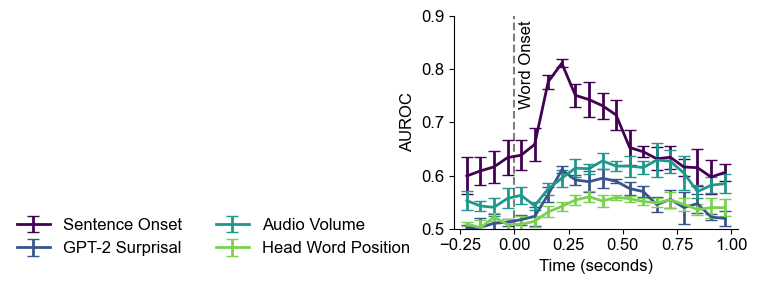

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'figures/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Calculate mean and std of test ROC AUC scores across folds for all features
mean_test_rocs = np.mean(test_roc_scores, axis=1) # Shape: (n_features, n_bins)
std_test_rocs = np.std(test_roc_scores, axis=1) # Shape: (n_features, n_bins)

# Create time points (in seconds) for x-axis
bin_times = (np.arange(n_bins)-bins_before_onset + 0.5) * (bin_size/2048)

# Get colors from viridis colormap spread across number of features
colors = plt.cm.viridis(np.linspace(0, .8, len(eval_names)))

# Create the plot
plt.figure(figsize=(8, 3))  # Increased width to accommodate legend

# Plot mean and error bars for each feature
for i, eval_name in enumerate(eval_names):
    plt.errorbar(bin_times, mean_test_rocs[i], yerr=std_test_rocs[i], 
                linewidth=2, color=colors[i], label=task_name_mapping[eval_name], capsize=4)

# Add vertical line at word onset (t=0) that goes up to 0.8
plt.vlines(x=0, ymin=0.5, ymax=1.0, color='k', linestyle='--', alpha=0.5)
plt.text(0.02, 0.98, 'Word Onset', rotation=90, 
         transform=plt.gca().get_xaxis_transform(),
         verticalalignment='top')

# Customize the plot
plt.xlabel('Time (seconds)')
plt.xticks([-0.25, 0, 0.25, 0.5, 0.75, 1])
plt.ylabel('AUROC')
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.legend(bbox_to_anchor=(-0.1, -0.2), loc='lower right', frameon=False, ncol=2)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set y-axis limits with some padding
plt.ylim(0.5, 0.9)

# Show the plot
plt.tight_layout()
plt.savefig('figures/linear_per_bin_auroc.pdf', dpi=300, bbox_inches='tight')